## a notebook to test setting up a custom sampling step

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

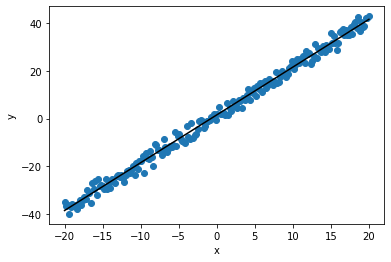

In [2]:
# generate test data, a linear system

b = [2,1.5]
sigma = 2

n = 200
x = np.linspace(start=-20,stop = 20, num = n)
y = b[0]*x+b[1]
y_obs = y + sigma*np.random.randn(n)

plt.plot(x,y,'k')
plt.scatter(x,y_obs)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## First, sample through pymc3 built in samplers

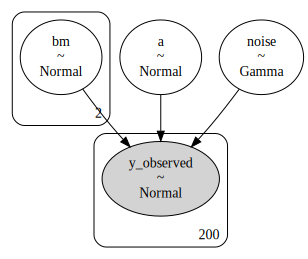

In [26]:
with pm.Model() as linear_model:

    bm = pm.Normal("bm", mu=0, sigma=2,shape=2)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    a = pm.Normal("a", mu=4, sigma=3,shape=1)

    y_observed = pm.Normal("y_observed",mu=bm[0]*x+bm[1]+a*x**2,sigma=noise,observed=y_obs)
pm.model_to_graphviz(linear_model)

In [27]:
posterior = pm.sample(model = linear_model,chains=2, draws=3000, tune=1000,return_inferencedata=True)

pm.summary(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, noise, bm]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bm[0],2.006,0.012,1.983,2.029,0.000,0.000,5374.0,4309.0,1.0
bm[1],1.122,0.216,0.675,1.489,0.004,0.003,3474.0,3514.0,1.0
a[0],0.002,0.001,-0.000,0.004,0.000,0.000,3394.0,3542.0,1.0
noise,1.990,0.099,1.800,2.172,0.001,0.001,4699.0,4013.0,1.0


## second, sample manually from a Gaussian

In [5]:
def my_sampler(mu=0,sigma=2):
    b = np.random.normal(mu,sigma,2)

    return b

In [6]:
my_sampler()

array([1.11355041, 1.52287655])

In [28]:
from pymc3.step_methods.arraystep import BlockedStep

class MySamplingStep(BlockedStep):
    def __init__(self, var, mu, sigma):
            self.vars = [var]
            self.var = var
            self.mu = mu
            self.sigma = sigma

    def step(self, point: dict):
        new = point.copy()
        new[self.var.name] = my_sampler(self.mu,self.sigma)

        return new

class ASamplingStep(BlockedStep):
    def __init__(self, var, mu, sigma):
            self.vars = [var]
            self.var = var
            self.mu = mu
            self.sigma = sigma

    def step(self, point: dict):
        new = point.copy()
        new[self.var.name] = np.random.normal(self.mu,self.sigma,1)

        return new

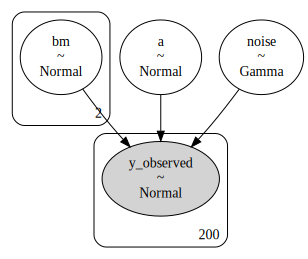

In [29]:
with pm.Model() as my_linear_model:
    bm = pm.Normal("bm", mu=0, sigma=2,shape=2)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    a = pm.Normal("a", mu=4, sigma=3,shape=1)

    y_observed = pm.Normal("y_observed",mu=bm[0]*x+bm[1]+a*x**2,sigma=noise,observed=y_obs)
    
pm.model_to_graphviz(my_linear_model)

In [31]:
mu = 3
sigma = 5

with my_linear_model:
    # step_bm = MySamplingStep(bm, mu, sigma)
    step_a = ASamplingStep(a,mu,sigma)
    posterior2 = pm.sample(step = [step_a], chains=2, draws=10000, tune=5000, cores = 1, return_inferencedata=True)

az.summary(posterior2)

Sequential sampling (2 chains in 1 job)
CompoundStep
>ASamplingStep: [a]
>NUTS: [noise, bm]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 129 seconds.
There were 765 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9229636430242132, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1814 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8944936811034744, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bm[0],0.752,1.723,-2.405,4.070,0.232,0.165,56.0,174.0,1.05
bm[1],-1.072,3.601,-8.023,5.820,0.260,0.184,198.0,277.0,1.00
a[0],2.972,5.008,-6.296,12.546,0.035,0.025,20476.0,20133.0,1.00
noise,422.085,261.088,3.190,721.905,7.281,5.150,497.0,236.0,1.01


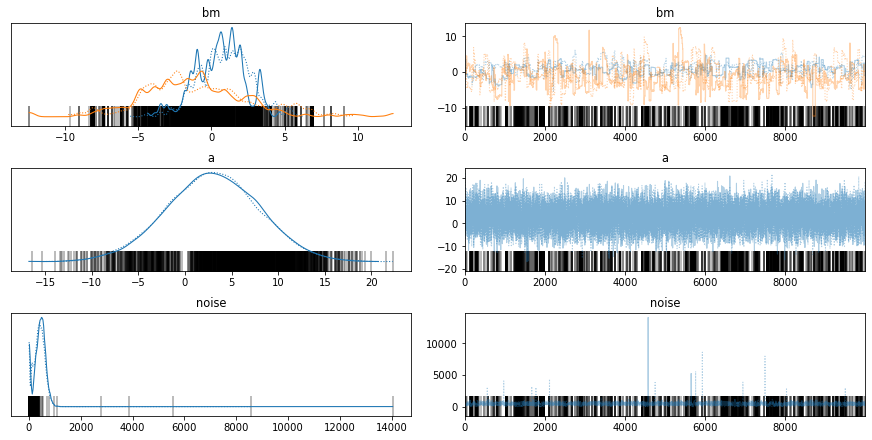

In [33]:
with my_linear_model:
    az.plot_trace(posterior2)